In [1]:
import pandas as pd
import ydata_profiling as ydp
import seaborn as sns
# 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
%matplotlib inline
from aux_functions.aux_plots import (plot_boxplot_histogram, plot_scatterplot, plot_distribution_actual_predicted)
from aux_functions.statistics import (test_pearson_correlation, apply_linear_regression, evaluate_linear_regression)

c:\Users\davig\anaconda3\envs\tecnico_sandbox\Lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
c:\Users\davig\anaconda3\envs\tecnico_sandbox\Lib\site-packages\visions\backends\shared\nan_handling.py:50: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @nb.jit


# Importing the dataset

In [2]:
columns = ['lenght_of_stay', 'age', 'infection_risk', 'routine_culturing_ratio', 'routine_xray_ratio', 'num_beds', 'med_school_affil', 'region', 'avg_census', 'num_nurses', 'avelbl_services']
df = pd.read_csv("data/dataset.txt", sep=" ", header=None, names=columns)
df.head()   

,lenght_of_stay,age,infection_risk,routine_culturing_ratio,routine_xray_ratio,num_beds,med_school_affil,region,avg_census,num_nurses,avelbl_services
1,7.13,55.7,4.1,9.0,39.6,279,2,4,207,241,60.0
2,8.82,58.2,1.6,3.8,51.7,80,2,2,51,52,40.0
3,8.34,56.9,2.7,8.1,74.0,107,2,3,82,54,20.0
4,8.95,53.7,5.6,18.9,122.8,147,2,4,53,148,40.0
5,11.20,56.5,5.7,34.5,88.9,180,2,1,134,151,40.0


In [3]:
df['ln_num_beds'] =  np.log(df['num_beds'])
df['ln_avg_census'] =  np.log(df['avg_census'])
df['ln_num_nurses'] =  np.log(df['num_nurses'])
df.drop(columns=['num_beds', 'avg_census', 'num_nurses'])

,lenght_of_stay,age,infection_risk,routine_culturing_ratio,routine_xray_ratio,med_school_affil,region,avelbl_services,ln_num_beds,ln_avg_census,ln_num_nurses
1,7.13,55.7,4.1,9.0,39.6,2,4,60.0,5.631212,5.332719,5.484797
2,8.82,58.2,1.6,3.8,51.7,2,2,40.0,4.382027,3.931826,3.951244
3,8.34,56.9,2.7,8.1,74.0,2,3,20.0,4.672829,4.406719,3.988984
4,8.95,53.7,5.6,18.9,122.8,2,4,40.0,4.990433,3.970292,4.997212
5,11.20,56.5,5.7,34.5,88.9,2,1,40.0,5.192957,4.897840,5.017280
...,...,...,...,...,...,...,...,...,...,...,...
109,11.80,53.8,5.7,9.1,116.9,1,2,62.9,6.347389,6.089045,6.150603
110,9.50,49.3,5.8,42.0,70.9,2,3,22.9,4.584967,4.219508,3.828641
111,7.70,56.9,4.4,12.2,67.9,2,4,62.9,4.859812,4.442651,4.912655
112,17.94,56.2,5.9,26.4,91.8,1,1,62.9,6.727432,6.673298,6.008813


In [4]:
# profile = ydp.ProfileReport(df, title="Profiling Report")
# profile.to_file("data_profile_v2.html")


In [5]:
df.head()

,lenght_of_stay,age,infection_risk,routine_culturing_ratio,routine_xray_ratio,num_beds,med_school_affil,region,avg_census,num_nurses,avelbl_services,ln_num_beds,ln_avg_census,ln_num_nurses
1,7.13,55.7,4.1,9.0,39.6,279,2,4,207,241,60.0,5.631212,5.332719,5.484797
2,8.82,58.2,1.6,3.8,51.7,80,2,2,51,52,40.0,4.382027,3.931826,3.951244
3,8.34,56.9,2.7,8.1,74.0,107,2,3,82,54,20.0,4.672829,4.406719,3.988984
4,8.95,53.7,5.6,18.9,122.8,147,2,4,53,148,40.0,4.990433,3.970292,4.997212
5,11.20,56.5,5.7,34.5,88.9,180,2,1,134,151,40.0,5.192957,4.897840,5.017280


# EDA

## Univariate analysis

### Measures of central tendency and dispersion

In [6]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)
df.describe()

,lenght_of_stay,age,infection_risk,routine_culturing_ratio,routine_xray_ratio,num_beds,med_school_affil,region,avg_census,num_nurses,avelbl_services,ln_num_beds,ln_avg_census,ln_num_nurses
count,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0
mean,9.6,53.2,4.4,15.8,81.6,252.2,1.8,2.4,191.4,173.2,43.2,5.3,4.9,4.8
std,1.9,4.5,1.3,10.2,19.4,192.8,0.4,1.0,153.8,139.3,15.2,0.7,0.8,0.8
min,6.7,38.8,1.3,1.6,39.6,29.0,1.0,1.0,20.0,14.0,5.7,3.4,3.0,2.6
25%,8.3,50.9,3.7,8.4,69.5,106.0,2.0,2.0,68.0,66.0,31.4,4.7,4.2,4.2
50%,9.4,53.2,4.4,14.1,82.3,186.0,2.0,2.0,143.0,132.0,42.9,5.2,5.0,4.9
75%,10.5,56.2,5.2,20.3,94.1,312.0,2.0,3.0,252.0,218.0,54.3,5.7,5.5,5.4
max,19.6,65.9,7.8,60.5,133.5,835.0,2.0,4.0,791.0,656.0,80.0,6.7,6.7,6.5


### Boxplots and histograms
* See "./imgs/box_hist" for results

In [7]:
cols = df.columns
for col in cols:
    if col != 'region' and col != 'med_school_affil':
        fig = plot_boxplot_histogram(df[col], col)
        fig.savefig(f'./imgs/box_hist/{col}.png')  # Save the figure

### Testing for normality on infection_risk

In [8]:
norm_test = sc.shapiro(np.array(df['infection_risk']))
print("Statistic of Shapiro Wilk test: ", norm_test.statistic)
print("p-value of Shapiro Wilk test: ", norm_test.pvalue)

Statistic of Shapiro Wilk test:  0.9820429682731628
p-value of Shapiro Wilk test:  0.1338874250650406


- Interpretation of S-W test: Since we had a small sample size, determining the distribution of the variable X was important for choosing an appropriate statistical method. So a Shapiro-Wilk test was performed and did not show evidence of non-normality (W = 0.98, p-value = 0.13).

## Bivariate analysis

### Calculating the correlation matrix

<Axes: >

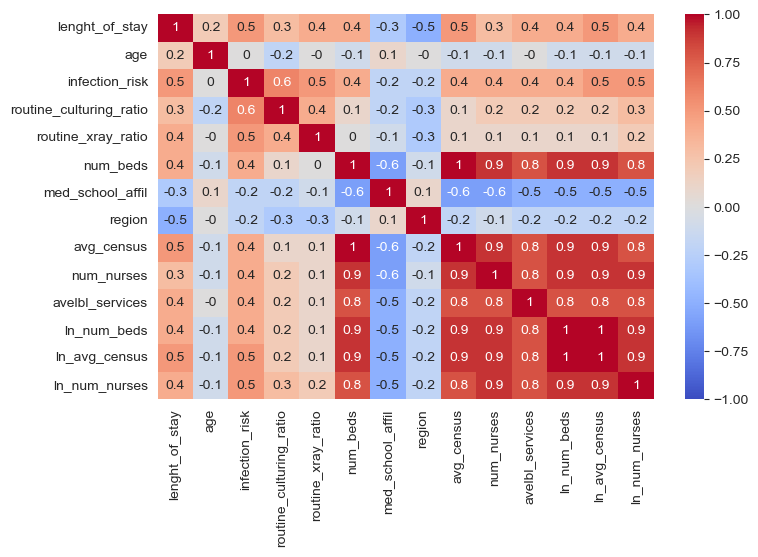

In [9]:
corr_matrix = round(df.corr(),1)
# corr_matrix
fig, ax = plt.subplots(figsize=(8,5))  
sns.heatmap(corr_matrix, annot = True, vmin=-1,vmax=1, cmap=sns.color_palette("coolwarm", as_cmap=True), ax=ax)
# sns.heatmap(corr_matrix, annot=True)

### Applying a pearson's correlation test

In [10]:
target_variable = 'infection_risk'
for col in ['lenght_of_stay', 'routine_culturing_ratio', 'ln_num_nurses']:
    pearson_res = test_pearson_correlation(df, col, target_variable)
    print(">> Pearson's correlation result for", col)
    print('Pearsons r:', round(pearson_res.statistic,2), ';', 'pValue:', round(pearson_res.pvalue,3))
    print(pearson_res.confidence_interval()) # Im not sure if this is a 0.95 confidence interval! Weirdly didn't find the info in the docs

>> Pearson's correlation result for lenght_of_stay
Pearsons r: 0.53 ; pValue: 0.0
ConfidenceInterval(low=0.3868337609236219, high=0.6537510724268812)
>> Pearson's correlation result for routine_culturing_ratio
Pearsons r: 0.56 ; pValue: 0.0
ConfidenceInterval(low=0.4175602271913731, high=0.6742438110841824)
>> Pearson's correlation result for ln_num_nurses
Pearsons r: 0.55 ; pValue: 0.0
ConfidenceInterval(low=0.4016417866999432, high=0.6636762697459764)


* Analysis: There is a statisticaly significant moderate linear correlation between lenght of stay and infection risk; and the same occurs for routine_culturing_ratio and infection risk

### Evaluating linear relationship between variables of interest

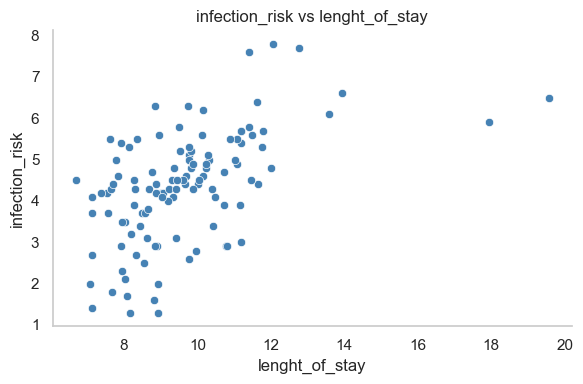

In [11]:
plot_scatterplot(df, 'lenght_of_stay', 'infection_risk')

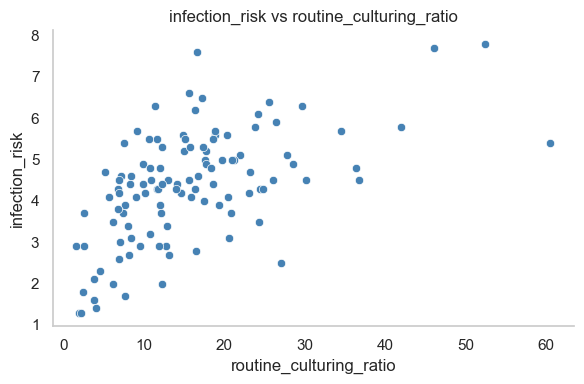

In [12]:
plot_scatterplot(df, 'routine_culturing_ratio', 'infection_risk')

log correlation 0.633145638294715


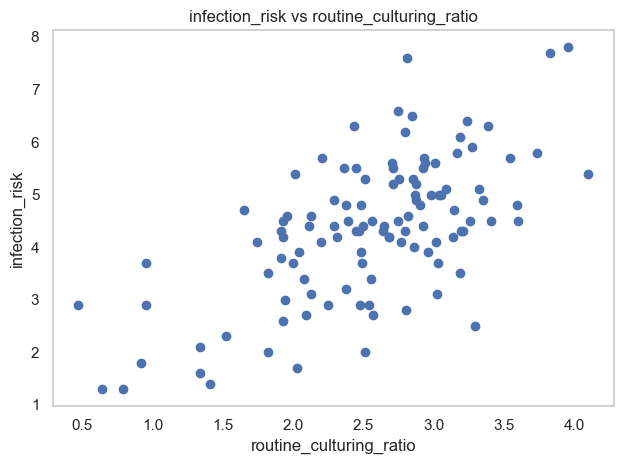

In [13]:
from scipy import stats
print("log correlation", stats.pearsonr(np.array(np.log(df.routine_culturing_ratio)), np.array(df.infection_risk)).statistic)

x= np.log(df.routine_culturing_ratio)
y = df.infection_risk

plt.scatter(x, y)
x_axis, y_axis = 'routine_culturing_ratio', 'infection_risk'
plt.title(f'{y_axis} vs {x_axis}')
plt.xlabel(x_axis)
plt.ylabel(y_axis)
plt.tight_layout()
plt.show()

* Analysis: it appears that the relationship between these variables is linear (is it though???? So subjective this)

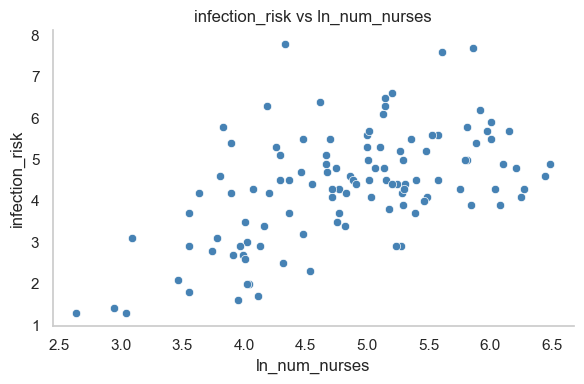

In [14]:
plot_scatterplot(df, 'ln_num_nurses', 'infection_risk')

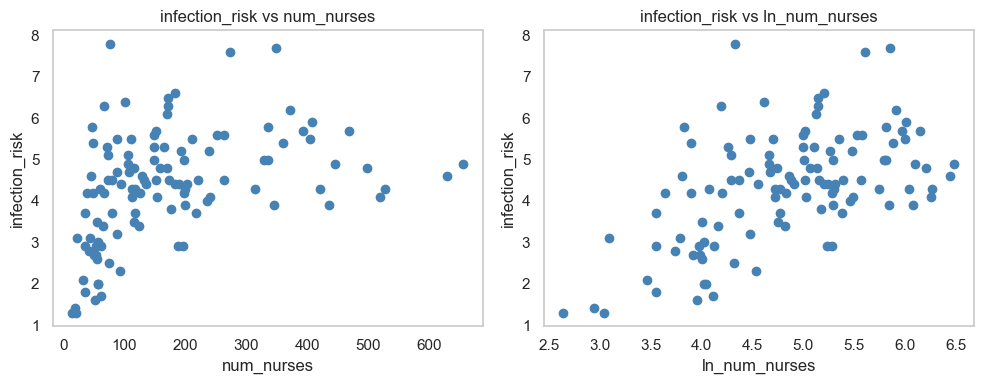

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
x1 = df['num_nurses']
x2 = df['ln_num_nurses']
y = df['infection_risk']
axs[0].scatter(x1, y, label='Scatter 1', color='steelblue', marker='o')
axs[0].set_title('infection_risk vs num_nurses')
axs[0].set_xlabel('num_nurses')
axs[0].set_ylabel('infection_risk')
axs[1].scatter(x2, y, label='Scatter 2', color='steelblue', marker='o')
axs[1].set_title('infection_risk vs ln_num_nurses')
axs[1].set_xlabel('ln_num_nurses')
axs[1].set_ylabel('infection_risk')
plt.tight_layout()
plt.show()

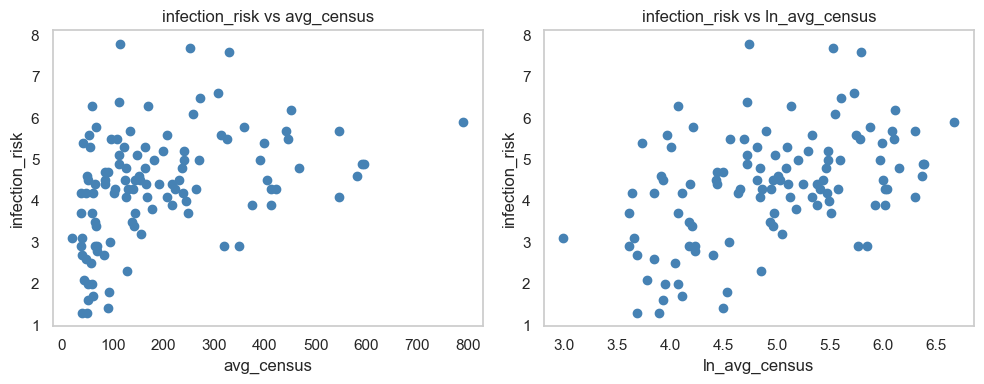

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
x1 = df['avg_census']
x2 = df['ln_avg_census']
y = df['infection_risk']
axs[0].scatter(x1, y, label='Scatter 1', color='steelblue', marker='o')
axs[0].set_title('infection_risk vs avg_census')
axs[0].set_xlabel('avg_census')
axs[0].set_ylabel('infection_risk')
axs[1].scatter(x2, y, label='Scatter 2', color='steelblue', marker='o')
axs[1].set_title('infection_risk vs ln_avg_census')
axs[1].set_xlabel('ln_avg_census')
axs[1].set_ylabel('infection_risk')
plt.tight_layout()
plt.show()